In [1]:
import math

import torch
import torch.nn.functional as F

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from ale_py import ALEInterface
from ale_py.roms import LostLuggage

from tqdm import tqdm

In [2]:
ale = ALEInterface()
ale.loadROM(LostLuggage)

In [3]:
env = gym.make('ALE/LostLuggage-v5')

In [4]:
from collections import defaultdict

class QLearningAgent:
    def __init__(self, n_actions,
                 learning_rate = 1e-4,
                 discount_factor = 1e-2,
                 epsilon = 0.05):
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.Q = defaultdict(lambda : torch.empty(n_actions))
    
    def choose_action(self, state):
        logits = self.Q[state] / 0.1
        action_probs = F.softmax(logits, dim=0)
        action = torch.multinomial(action_probs, 1).item()
        return action
    
    def update_Q(self, state, action, reward):
        max_Q = torch.argmax(self.Q[state])
        current_Q = self.Q[state][action]
        td_target = reward + self.discount_factor * max_Q
        td_error = td_target - current_Q
        self.Q[state][action] += self.learning_rate * td_error

    def train(self, env, n_episodes):
        episode_rewards = []

        for _ in tqdm(range(n_episodes)):
            env.reset()
            done = False
            total_reward = 0
            state = str()

            while not done:
                action = self.choose_action(state)
                next_state, reward, done, _, _ = env.step(action)
                total_reward += reward
                self.update_Q(state, action, reward)
                state = str(next_state)
            
            episode_rewards.append(total_reward)
        
        return episode_rewards

In [5]:
n_episodes = 1000

agent = QLearningAgent(n_actions=env.action_space.n)

In [6]:
episode_rewards = agent.train(env=env, n_episodes=n_episodes)

100%|██████████| 1000/1000 [20:32<00:00,  1.23s/it]


Text(0.5, 1.0, 'Q-Learning Total Rewards')

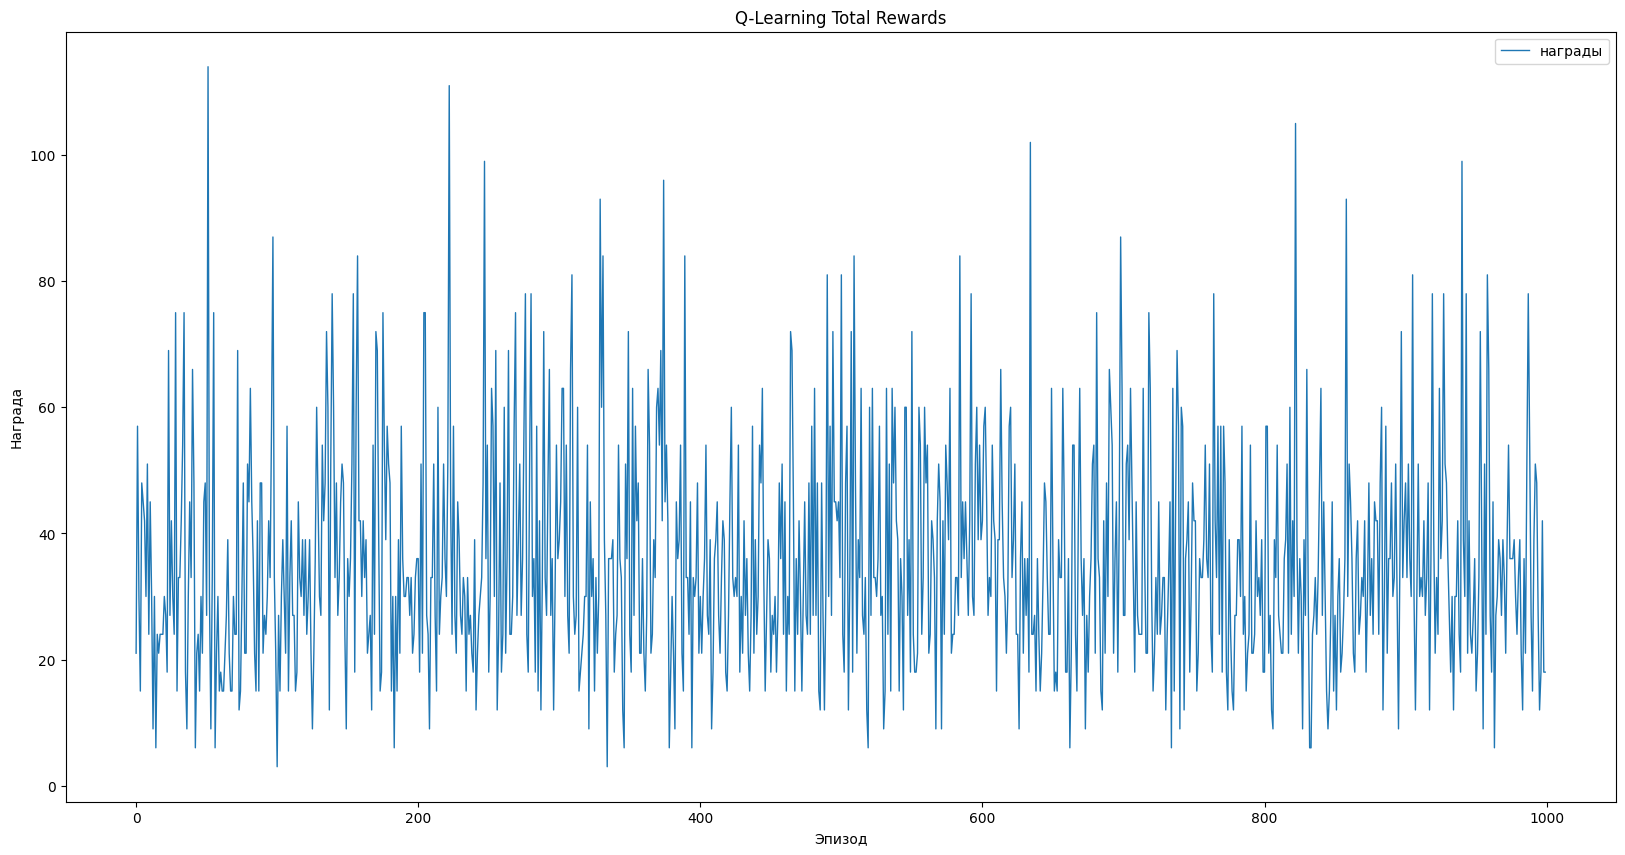

In [27]:
plt.figure(figsize=(20, 10))
plt.plot(range(n_episodes), episode_rewards, linewidth=1)
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.legend(['награды'])
plt.title('Q-Learning Total Rewards')

In [8]:
mean_reward = np.mean(episode_rewards)
std_reward = np.std(episode_rewards)

In [9]:
print(f'Математическое ожидание: {mean_reward}')
print(f'Стандартное отклонение: {std_reward}')

Математическое ожидание: 35.748
Стандартное отклонение: 17.742899875724937


In [22]:
delta = 0.1

In [23]:
lower_bound = mean_reward - 1.645 * (std_reward / math.sqrt(300))

In [24]:
upper_bound = mean_reward + 1.645 * (std_reward / math.sqrt(300))

In [25]:
print(f'({lower_bound}, {upper_bound})')

(34.06288371079975, 37.43311628920024)


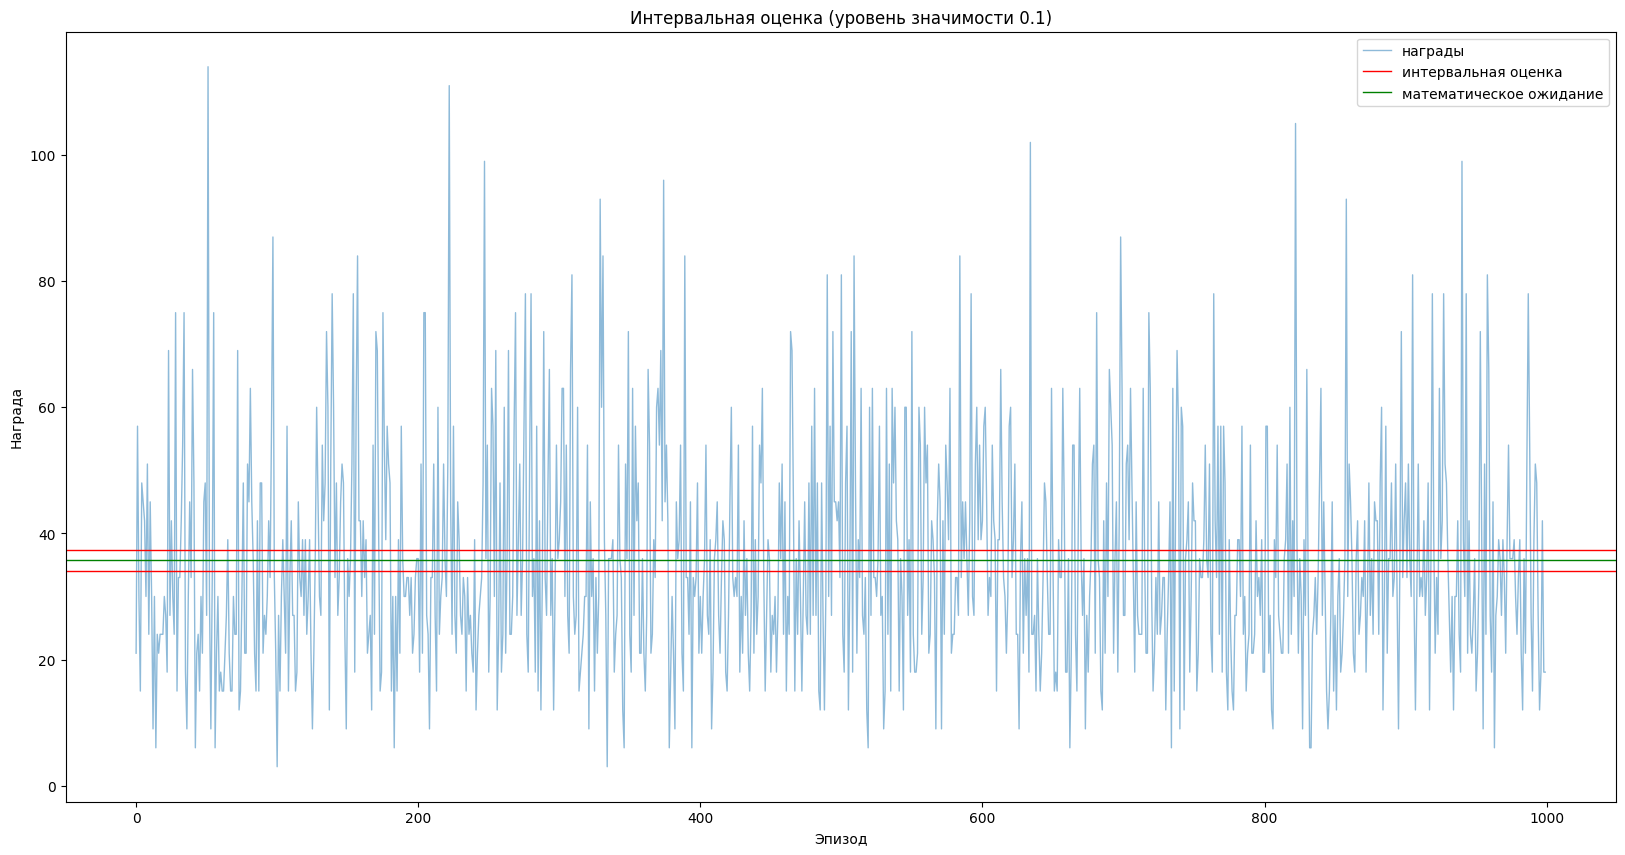

In [26]:
plt.figure(figsize=(20, 10))
plt.plot(range(n_episodes), episode_rewards, linewidth = 1, alpha = 0.5)
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Интервальная оценка (уровень значимости 0.1)')
plt.axhline(upper_bound, linewidth=1, color='red')
plt.axhline(mean_reward, linewidth=1, color='green')
plt.axhline(lower_bound, linewidth=1, color='red')
plt.legend(['награды', 'интервальная оценка', 'математическое ожидание'])
plt.show()

In [15]:
delta = 0.1

In [16]:
lower_bound = mean_reward - 1.96 * (std_reward / math.sqrt(300))

In [17]:
upper_bound = mean_reward + 1.96 * (std_reward / math.sqrt(300))

In [18]:
print(f'({lower_bound}, {upper_bound})')

(33.740201868186944, 37.75579813181305)


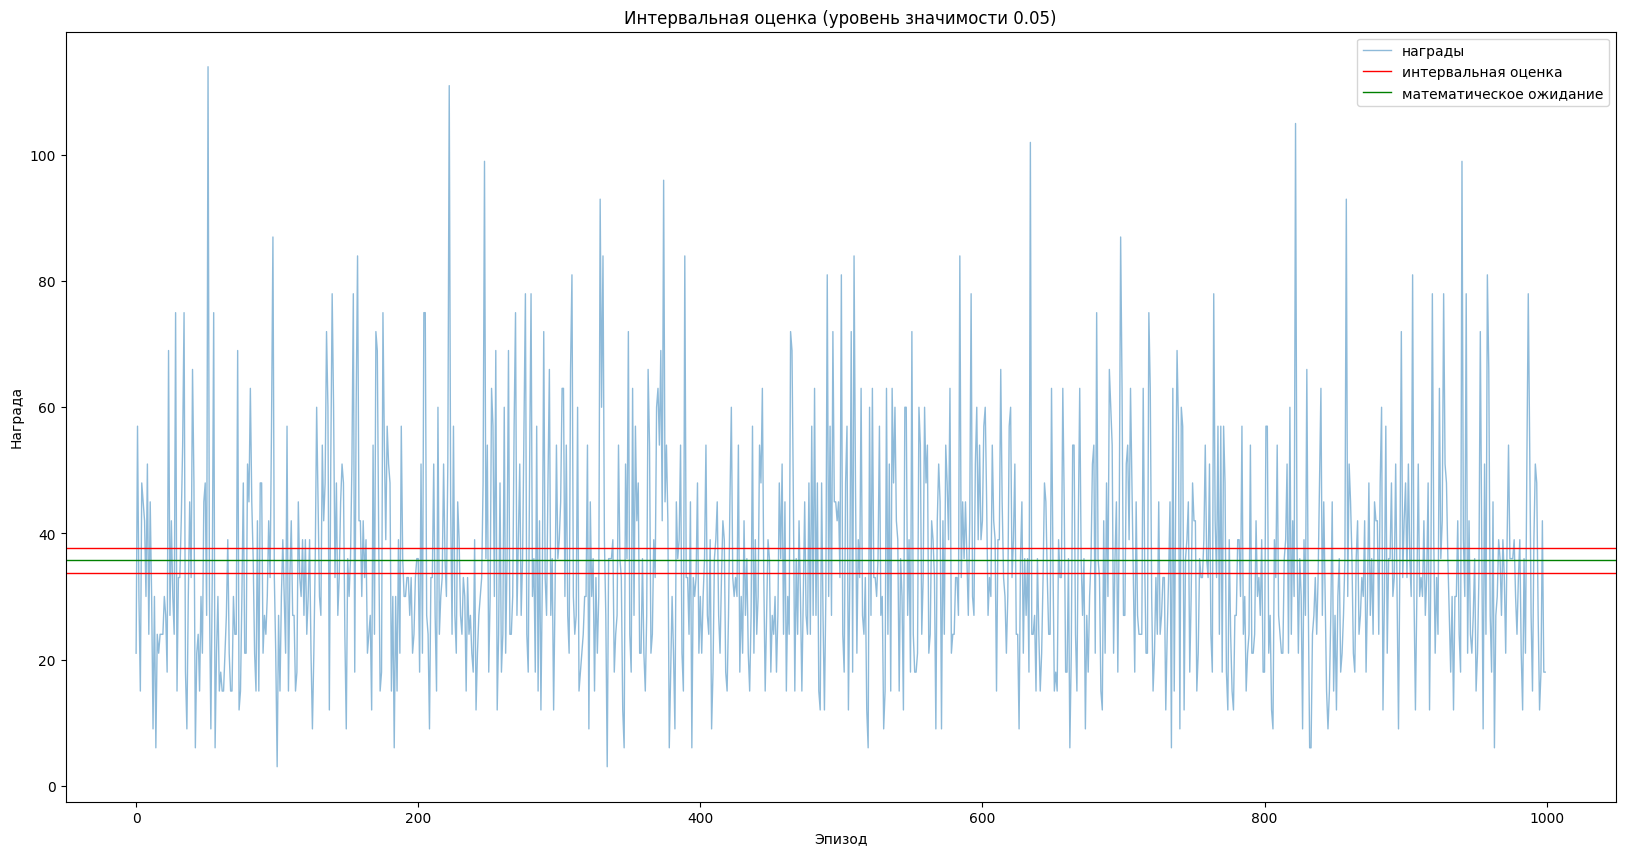

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(range(n_episodes), episode_rewards, linewidth = 1, alpha = 0.5)
plt.xlabel('Эпизод')
plt.ylabel('Награда')
plt.title('Интервальная оценка (уровень значимости 0.05)')
plt.axhline(upper_bound, linewidth=1, color='red')
plt.axhline(mean_reward, linewidth=1, color='green')
plt.axhline(lower_bound, linewidth=1, color='red')
plt.legend(['награды', 'интервальная оценка', 'математическое ожидание'])
plt.show()